In [1]:
import numpy as np
import matplotlib.pyplot as plt
import celerite as celery
import exoplanet as xo
import pymc3 as pm
import theano
import theano.tensor as tt
from exoplanet.gp import terms, GP

In [2]:
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing" # thx dfm

In [3]:
xo.__version__

'0.2.6'

In [4]:
np.random.seed(42)

#### generate RVs on a dense grid of times:

In [5]:
log_S0 = -1.0
log_Q = 7.0
log_omega0 = np.log(2.*np.pi / 300.) # 5-minute period

In [6]:
kernel_onemode = celery.terms.SHOTerm(log_S0, log_Q, log_omega0)

In [7]:
dt = 10. # grid spacing (s)
duration = 4. * 3600. # 4 hours
t_all = np.arange(0, duration, dt)

In [8]:
gp = celery.GP(kernel_onemode)
gp.compute(t_all)
y_all = gp.sample()

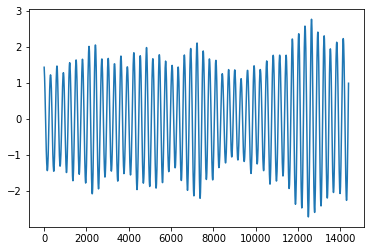

In [9]:
plt.plot(t_all, y_all);

#### bin down to simulate longer exposures:

In [10]:
from scipy.interpolate import interp1d

In [11]:
t = []
y = []

exp_time = 4. * 60.
n_exp = int(duration/exp_time) - 2

interp = interp1d(t_all, y_all, kind='cubic')
tiny = 0.1 # 100 ms
for n in range(n_exp):
    stt = 100. + n*exp_time # start time for this exposure, assumes no read time
    fine_ts = np.arange(stt, stt+exp_time, tiny) # fine grid
    fine_rvs = interp(fine_ts)
    avg_rv = np.sum(fine_rvs)/len(fine_rvs) # technically incorrect but close enough
    y.append(avg_rv)
    t.append(stt + exp_time/2.)

t = np.array(t)
y = np.array(y)

In [12]:
validation_inds = np.sort(np.random.choice(len(t), size=int(len(t)/2), replace=False)) # 50% of epochs as validation
validation_mask = np.isin(np.arange(len(t)), validation_inds)
t_val = t[validation_mask]
y_val = y[validation_mask]
t_obs = t[~validation_mask]
y_obs = y[~validation_mask]

In [13]:
# add photon noise:
noise_amp = 0.5
yerr_obs = np.zeros_like(y_obs) + noise_amp
y_obs += np.random.normal(0., noise_amp, len(y_obs))

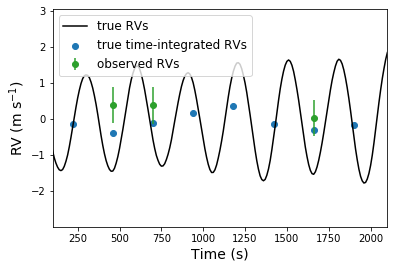

In [14]:
plt.plot(t_all, y_all, c='k', label='true RVs')
plt.scatter(t, y, c='C0', label='true time-integrated RVs')
plt.errorbar(t_obs, y_obs, yerr_obs, c='C2', label='observed RVs', ls='', marker='o')
plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel(r'RV (m s$^{-1}$)', fontsize=14)
plt.xlim([100,2100]);

#### model with a non-integrated kernel:

This shouldn't work too well.

In [15]:
t_plot = np.linspace(100, 2100, 100)
with pm.Model() as model:
    kernel = terms.SHOTerm(log_S0=log_S0, log_w0=log_omega0, log_Q=log_Q)
    gp = GP(kernel, t_obs, yerr_obs ** 2)
    gp.condition(y_obs)
    mu, var = xo.eval_in_model(gp.predict(t_plot, return_var=True))
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict())
    y_val_pred = xo.eval_in_model(gp.predict(t_val))

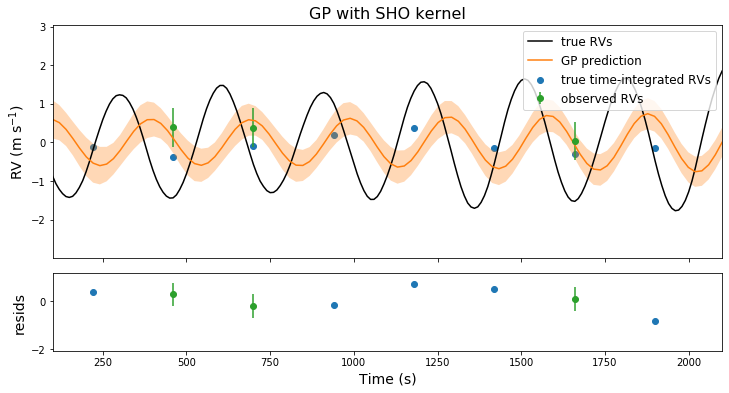

In [16]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,6), sharex=True, 
                              gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})

ax1.plot(t_all, y_all, c='k', label='true RVs')
ax1.scatter(t, y, c='C0', label='true time-integrated RVs')
ax1.errorbar(t_obs, y_obs, yerr_obs, c='C2', label='observed RVs', ls='', marker='o')
art = ax1.fill_between(t_plot, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
ax1.plot(t_plot, mu, color="C1", label='GP prediction')
ax1.legend(fontsize=12)
ax2.errorbar(t_obs, y_obs - y_pred, yerr_obs, c='C2', ls='', marker='o')
ax2.scatter(t_val, y_val - y_val_pred, c='C0')
ax2.set_xlabel('Time (s)', fontsize=14)
ax1.set_ylabel(r'RV (m s$^{-1}$)', fontsize=14)
ax2.set_ylabel(r'resids', fontsize=14)
ax1.set_xlim([100,2100])
ax1.set_title('GP with SHO kernel', fontsize=16);

#### model with an integrated kernel:

This *should* work well.

In [17]:
t_plot = np.linspace(100, 2100, 100)
with pm.Model() as model:
    kernel = terms.SHOTerm(log_S0=log_S0, log_w0=log_omega0, log_Q=log_Q)
    kernel_int = terms.IntegratedTerm(kernel, exp_time)
    gp = GP(kernel_int, t_obs, yerr_obs ** 2)
    gp.condition(y_obs)
    mu, var = xo.eval_in_model(gp.predict(t_plot, return_var=True, kernel=kernel_int))
    mu_nonint = xo.eval_in_model(gp.predict(t_plot, kernel=kernel))
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict()) # predictions for training data
    y_val_pred = xo.eval_in_model(gp.predict(t_val))# predictions for validation set

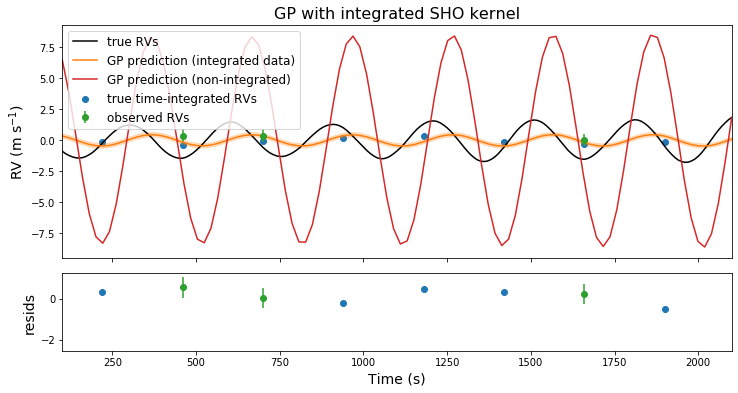

In [18]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,6), sharex=True, 
                              gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})

ax1.plot(t_all, y_all, c='k', label='true RVs')
ax1.scatter(t, y, c='C0', label='true time-integrated RVs')
ax1.errorbar(t_obs, y_obs, yerr_obs, c='C2', label='observed RVs', ls='', marker='o')
art = ax1.fill_between(t_plot, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
ax1.plot(t_plot, mu, color="C1", label='GP prediction (integrated data)')
ax1.plot(t_plot, mu_nonint, color="C3", label='GP prediction (non-integrated)')
ax1.legend(fontsize=12)
ax2.errorbar(t_obs, y_obs - y_pred, yerr_obs, c='C2', ls='', marker='o')
ax2.scatter(t_val, y_val - y_val_pred, c='C0')
ax2.set_xlabel('Time (s)', fontsize=14)
ax1.set_ylabel(r'RV (m s$^{-1}$)', fontsize=14)
ax2.set_ylabel(r'resids', fontsize=14)
ax1.set_xlim([100,2100])
ax1.set_title('GP with integrated SHO kernel', fontsize=16);